# Login / Switch DEV_TEST_PROD environment (1-timer)

In [1]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/esml/common/")
from azureml.core.authentication import InteractiveLoginAuthentication
from esml import ESMLProject

p = ESMLProject()
p.dev_test_prod="dev"

print(p.tenant)
print(p.workspace_name) # self.workspace_name,subscription_id = self.subscription_id,resource_group = self.resource_group
print(p.subscription_id)
print(p.resource_group)

auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
#auth = InteractiveLoginAuthentication(force=True, tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL
72f988bf-86f1-41af-91ab-2d7cd011db47
msft-weu-DEV-eap-proj02_ai-amls
ca0a8c40-b06a-4e4e-8434-63c03a1dee34
MSFT-WEU-EAP_PROJECT02_AI-DEV-RG


# 1) ESML - TRAIN Classification, TITANIC model, and DEPLOY with predict_proba scoring

In [2]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLProject
import pandas as pd

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.active_model = 10
p.inference_mode = False
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace
p.verbose_logging = False
p.describe()

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL
Environment: dev
Inference version: 1

 - ds01_titanic
projects/project002/10_titanic_model_clas/train/ds01_titanic/in/dev/1000/01/01/
projects/project002/10_titanic_model_clas/train/ds01_titanic/out/bronze/dev/
projects/project002/10_titanic_model_clas/train/ds01_titanic/out/silver/dev/

 - ds02_haircolor
projects/project002/10_titanic_model_clas/train/ds02_haircolor/in/dev/1000/01/01/
projects/project002/10_titanic_model_clas/train/ds02_haircolor/out/bronze/dev/
projects/project002/10_titanic_model_clas/train/ds02_haircolor/out/silver/dev/

 - ds03_housing
projects/project002/10_titanic_model_clas/train/ds03_housing/in/dev/1000/01/01/
projects/project002/10_titanic_model_clas/train/ds03_housing/out/bronze/dev/
projects/project002/10_titanic_model_clas/train/ds03_housing/out/silver/dev/

 - ds04_lightsaber
projects/project002/10_titanic_model_clas/train/ds04_lightsaber/in/dev/1000/01/01/
projects/pro

In [3]:
p.ws

Workspace.create(name='msft-weu-DEV-eap-proj02_ai-amls', subscription_id='ca0a8c40-b06a-4e4e-8434-63c03a1dee34', resource_group='MSFT-WEU-EAP_PROJECT02_AI-DEV-RG')

In [4]:
unregister_all_datasets=False
if(unregister_all_datasets):
    p.unregister_all_datasets(p.ws) # For DEMO purpose

In [5]:
def test_feature_engieering():
    # R&D purpose: Try some data wrangling here...we will later incorporate this in an Azure ML Pipeline, as "steps"
    esml_dataset = p.DatasetByName("ds01_titanic") 
    df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
    df_bronze.columns = df_bronze.columns.str.replace("[/]", "_") # Rename werid column names

    df_silver = p.save_silver(esml_dataset,df_bronze) #Bronze -> Silver

    esml_dataset2 = p.DatasetByName("ds02_haircolor")
    esml_dataset3 = p.DatasetByName("ds03_housing")
    esml_dataset4 = p.DatasetByName("ds04_lightsaber")

    p.save_silver(esml_dataset2,esml_dataset2.Bronze.to_pandas_dataframe()) #Bronze -> Silver
    p.save_silver(esml_dataset3,esml_dataset3.Bronze.to_pandas_dataframe()) #Bronze -> Silver
    p.save_silver(esml_dataset4,esml_dataset4.Bronze.to_pandas_dataframe()) #Bronze -> Silver

    gold = p.save_gold(esml_dataset.Silver.to_pandas_dataframe())  #Silver -> Gold STEP
    return gold

In [6]:
datastore = None
try:
    datastore = p.connect_to_lake() # Connects to the correct ALDS GEN 2 storage account (DEV, TEST or PROD)
    gold_train = p.GoldTrain
    gold_train.name
    print("Not 1st time. We have data mapped already...and splitted. Now connected to LAKE")
except: # If 1st time....no Gold exists, nor any mapping
    print("1st time. Lets init, map what data we have in LAKE, as Azure ML Datasets")
    datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
    gold = test_feature_engieering()

Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = TRUE 
 - Found settings in the ESML AutoLake  [active_in_folder.json,active_scoring_in_folder.json], to override ArgParse/GIT config with.
 - TRAIN in date:  1000/01/01
 - INFERENCE in date: 2021/06/08 and ModelVersion to score with: 1 (0=latest)
Not 1st time. We have data mapped already...and splitted. Now connected to LAKE


In [7]:
p.Gold.to_pandas_dataframe().head()

,Survived,Pclass,Name,Sex,Age,Siblings_Spouses Aboard,Parents_Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## SUMMARY - step 1
- ESML has now `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
- ESML has read configuration for correct environment (DEV, TEST, PROD). 
    - Both small customers, and large Enterprise customers often wants:  DEV, TEST, PROD in `diffferent Azure ML workspaces` (and different subscriptions)
- User has done feature engineering, and saved GOLD `p.save_gold`

In [8]:
print("rows in GOLD {}".format(p.Gold.to_pandas_dataframe().shape[0]))

rows in GOLD 887


In [9]:
M10_GOLD_TRAIN, M10_GOLD_VALIDATE, M10_GOLD_TEST = p.split_gold_3(0.6,stratified=False) # Splits and Auto-registers as AZUREM ML Datasets

...


# IN_2_GOLD
- If just wanting to refine data to GOLD, for a Power BI report (No ML involved)
- Scenario: You want to refine data from "IN_2_GOLD" with an easy way to READ/WRITE data (using the enterprise datalake via ESML AutoLake and ESML SDK)

In [10]:
p.GoldTrain.to_pandas_dataframe().head()  # Azure ML Dataset

,Survived,Pclass,Name,Sex,Age,Siblings_Spouses Aboard,Parents_Children Aboard,Fare
0,1,1,Mr. Adolphe Saalfeld,male,47.0,0,0,30.5000
1,0,2,Mr. Joseph Philippe Lemercier Laroche,male,25.0,1,2,41.5792
2,0,3,Mr. Samuel Beard Risien,male,69.0,0,0,14.5000
3,1,1,Col. Oberst Alfons Simonius-Blumer,male,56.0,0,0,35.5000
4,0,2,Rev. Charles Leonard Kirkland,male,57.0,0,0,12.3500


# 2) `ESML` Train model in `5 codelines`

In [11]:
p.dev_test_prod

'dev'

In [12]:
automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
automl_performance_config

Loading AutoML config settings from: dev


{'enable_voting_ensemble': True,
 'enable_stack_ensemble': False,
 'model_explainability': True,
 'experiment_timeout_hours': 0.75,
 'iteration_timeout_minutes': 5,
 'n_cross_validations': 3,
 'enable_early_stopping': False,
 'iterations': 21,
 'max_cores_per_iteration': -1,
 'allowed_models': ['LightGBM', 'DecisionTree', 'ExtremeRandomTrees', 'KNN'],
 'path': '.',
 'debug_log': 'azure_automl_debug_dev.log'}

In [13]:
print('Label is: {}'.format(p.active_model["label"]))

Label is: Survived


In [14]:
from esml import ESMLProject
from baselayer_azure_ml import AutoMLFactory,azure_metric_regression,azure_metric_classification
from azureml.train.automl import AutoMLConfig

automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
aml_compute = p.get_training_aml_compute(p.ws) # 2)Get compute, for active environment

automl_config = AutoMLConfig(task = 'classification', # 4) Override the ENV config, for model(that inhertits from enterprise DEV_TEST_PROD config baseline)
                            primary_metric = azure_metric_classification.AUC, # # Note: Regression(MAPE) are not possible in AutoML
                            compute_target = aml_compute,
                            training_data = p.GoldTrain, # is 'train_6' pandas dataframe, but as an Azure ML Dataset
                            experiment_exit_score = '0.622', # DEMO purpose (0.308 for diabetes regression, 0.6 for classification titanic)
                            label_column_name = p.active_model["label"],
                            **automl_performance_config
                        )
via_pipeline = False # Consistent/same return values from both AutoML ALTERNATIVES (run or pipeline)
best_run, fitted_model, experiment = AutoMLFactory(p).train_pipeline(automl_config) if via_pipeline else AutoMLFactory(p).train_as_run(automl_config)

Loading AutoML config settings from: dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Using a model specific cluster, per configuration in project specific settings, (the integer of 'model_number' is the base for the name)
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster p02-m10weu-dev for project and environment, using it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
image_build_compute = p02-m10weu-dev
Experiment name: 10_titanic_model_clas
Azure ML Studio Workspace: msft-weu-DEV-eap-proj02_ai-amls
Start training run...
Submitting remote run.
No run_configuration provided, running on p02-m10weu-dev with default configuration
Ru

Experiment,Id,Type,Status,Details Page,Docs Page
10_titanic_model_clas,AutoML_cad3bde7-19f2-4685-abea-07483b7e7352,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

********************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFea

- ESML has now fetched `configuration & train compute` for enterprise `environment (DEV,TEST or PROD)`
- ESML has `autogenerated` a AutoML-experiment, optinally as `pipline`, in correct environment.
- User has overridden some AutoML settings (`label, split percentage`, `target metric`), and use the `1-liner TRAIN` code snippet 

# 3) Production purpose: "once and only once": Wrap code
- 3 Callers: MLOps, AMLPipeline, and this notebook

import sys
sys.path.insert(0, "../../2_A_aml_pipeline/4_inference/batch/M10/your_code/")
from your_custom_code import M01In2GoldProcessor

#p.init()
esml_dataset1 = p.DatasetByName("ds01_titanic") # Get dataset 1
df_bronze = esml_dataset1.Bronze.to_pandas_dataframe()
silver1 = p.save_silver(esml_dataset1,df_bronze) #Bronze -> Silver

esml_dataset2 = p.DatasetByName("ds02_haircolor") # Get dataset 2
df_bronze2 = esml_dataset2.Bronze.to_pandas_dataframe()
silver2 = p.save_silver(esml_dataset2,df_bronze2) #Bronze -> Silver

df1 = M01In2GoldProcessor().M01_ds01_process_in2silver(silver1.to_pandas_dataframe())  # You can then copy this statement in your pipeline-step "in2silver_ds01...py"
df2 = M01In2GoldProcessor().M01_ds02_process_in2silver(silver2.to_pandas_dataframe())  # You can then copy this statement in your pipeline-step "in2silver_ds02...py"

merged_gold = M01In2GoldProcessor().M01_merge_silvers(df1,df2) # # You can then copy this statement in your pipeline-step "silver_merged_2_gold.py"
p.save_gold(merged_gold).to_pandas_dataframe().head()

## 2b) ESML Scoring Drift/Concept Drift: Compare with `1-codeline`: Promote model or not? If better, then `Register model`
- `IF` newly trained model in `current` environment (`DEV`, `TEST` or `PROD`) scores BETTER than existing model in `target` environment, then `new model` can be registered and promoted.
- Q: Do we have `SCORING DRIFT / CONCEPT DRIFT?`
- Q: Is a model trained on NEW data better? IS the one in production degraded? (not fit for the data it scores - real world changed, other CONCEPT)
- A: - Lets check. Instead of `DataDrift`, lets look at `actual SCORING` on new data (and/or new code, feature engineering) - See if we should PROMOTE newly trained model...

In [15]:
print("current AI Factory environment: '{}' - AML WS: '{}'".format(p.dev_test_prod, p.ws.name))

current AI Factory environment: 'dev' - AML WS: 'msft-weu-DEV-eap-proj02_ai-amls'


In [16]:
from baselayer_azure_ml_model import ESMLModelCompare

current_env = p.dev_test_prod # dev
target_env = "dev" # Does newly trained Model v3 in DEV, score better than Model v2 in TEST?
print("promote model in DEV to TEST? (move to other Azure ML Studio Workspace)")

compare = ESMLModelCompare(p)
promote,source_model_name,new_run_id,target_model_name, target_best_run_id,target_workspace,source_model = compare.compare_scoring_current_vs_new_model(target_env) # Compare DEV to TEST (or TEST to PROD)  (1min, 17sek VS 33sec)

print("SCORING DRIFT: If new model scores better in DEV (new data, or new code), we can promote this to TEST & PROD \n")
print("New Model: {} in environment {}".format(target_model_name, p.dev_test_prod))
print("Existing Model: {} in environment {}".format(source_model_name,target_env))

if (promote): # Can register="promote" a model in same workspace (test->test), or also register in OTHER Azure ML workspace (test->prod)
    if(p.dev_test_prod == target_env):
        compare.register_active_model(target_env,source_model) # if SAME workspace this brings more "metadata" faster to the model registration
    else:
        compare.register_model_in_correct_ws(target_env) # if REMOTE target workspace we can get same metadata, BUT, just takes performancewise longer. More lookups to "source Run"

promote model in DEV to TEST? (move to other Azure ML Studio Workspace)
target=source environement. Compare model version in DEV/TEST/PROD with latest registered in same DEV/TEST/PROD workspace (same workspace & subscriptiom comparison)

new_run_id AutoML_cad3bde7-19f2-4685-abea-07483b7e7352
active_model_config from 'automl_active_model_env.json': source_model_name: AutoMLcad3bde710
Could not find EXISTING MODEL with same experiment name = No TARGET run. This is the first model to be trained in environment: dev, nothing to compare against -> Go ahead and register & deploy new model
TARGET is in the same Azure ML Studio workspace as SOURCE, comparing with latest registered model...
target_best_run_id AutoML_b31f30ef-87bb-48cd-9fba-90aff870681f
SCORING DRIFT: If new model scores better in DEV (new data, or new code), we can promote this to TEST & PROD 

New Model: AutoMLb31f30ef80 in environment dev
Existing Model: AutoMLcad3bde710 in environment dev
model.version 1
Model name AutoMLcad3

# TEST SET SCORING

# Test-set: Ensure we have a TEST_SET splitted

In [17]:
label = p.active_model["label"]
try:
    p.GoldTest.name
except: 
    p.connect_to_lake() # p.init() + automap
    train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6)

...


### NOW we can calcualate scoring on TEST_SET

...
Replacing tag run_id -> AutoML_cad3bde7-19f2-4685-abea-07483b7e7352 with run_id -> AutoML_cad3bde7-19f2-4685-abea-07483b7e7352
Replacing tag model_name -> AutoMLcad3bde710 with model_name -> AutoMLcad3bde710
Replacing tag trained_in_environment -> dev with trained_in_environment -> dev
Replacing tag trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls with trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls
Replacing tag experiment_name -> 10_titanic_model_clas with experiment_name -> 10_titanic_model_clas
Replacing tag status_code -> esml_newly_trained with status_code -> esml_newly_trained
Replacing tag test_set_ROC_AUC -> 0.834775 with test_set_ROC_AUC -> 0.834775
Replacing tag test_set_Accuracy -> 0.780899 with test_set_Accuracy -> 0.780899
Replacing tag test_set_F1_Score -> 0.719424 with test_set_F1_Score -> 0.719424
Replacing tag test_set_Precision -> 0.641838 with test_set_Precision -> 0.641838
Replacing tag test_set_Recall -> 0.694444 with test_set_Recall -> 0.694444

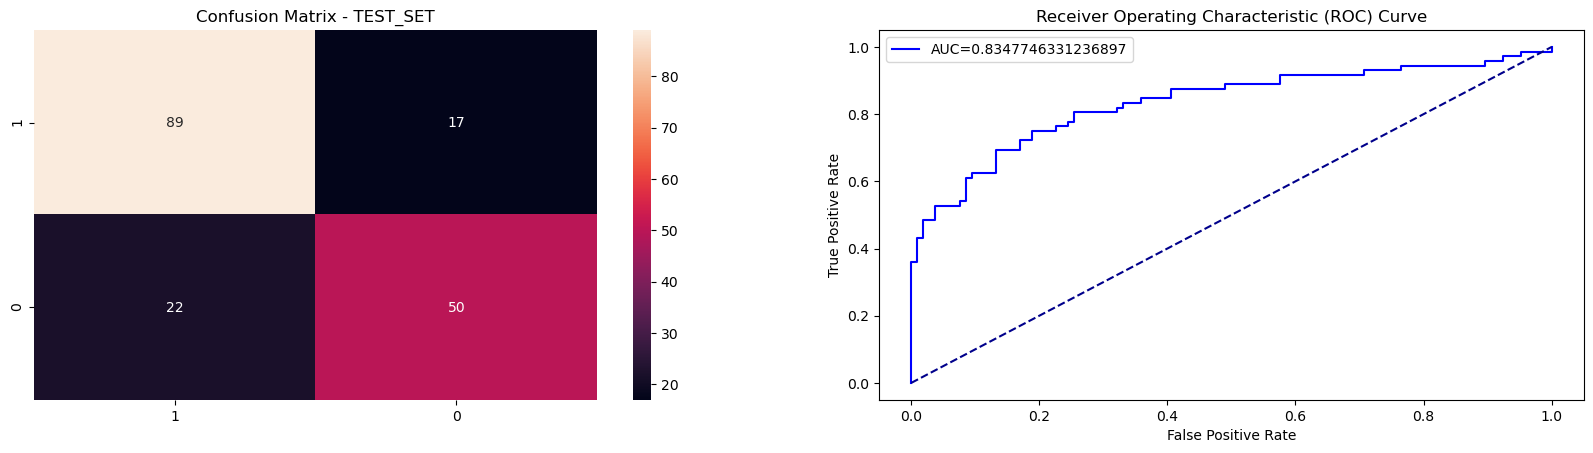

In [18]:
from baselayer_azure_ml import ESMLTestScoringFactory

auc,accuracy,f1, precision,recall,matrix,matthews,plt = ESMLTestScoringFactory(p).get_test_scoring_7_classification()

print("AUC:")
print(auc)
print()
print("Accuracy:")
print(accuracy)
print()
print("F1 Score:")
print(f1)
print()
print("Precision:")
print(precision)
print()
print("Recall:")
print(recall)
print()
print("Mathews correlation:")
print(matthews)
print()
print("Confusion Matrix:")
print(matrix)

...


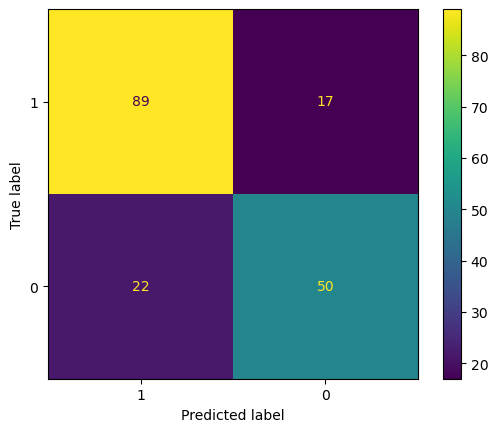

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = p.GoldTest.to_pandas_dataframe()[p.active_model["label"]].unique()
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
p1 = disp.plot()

# 3) ESML `Deploy model ONLINE` in `2 lines of code` (AKS) 
- Deploy "offline" MODEL from old `run` in environment To →  `DEV`, `TEST` or `PROD` environment
- ESML saves `API_key in Azure keyvault automatically`
- ESML auto-config solves 4 common 'errors/things': `correct compute name` and `valid replicas, valid agents, valid auto scaling`
    - Tip: You can adjust the number of replicas, and different CPU/memory configuration, or using a different compute target.

In [31]:
inference_config, model, best_run = p.get_active_model_inference_config(p.ws) #  Get compute power & lib-dependecies for DOCKER...for correct (Dev,Test or Prod) environment.
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config,overwrite_endpoint=True) # Deploy: AKS dockerized with correct config (Dev,Test or Prod subscription & networking)

Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Loading AutoML config settings from: dev
Deploying model: AutoML4b3c03dfe18 with verison: 7 to environment: dev with overwrite_endpoint=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
image_build_compute = prj02-m10-dev
Found existing AksWebservice endpoint, deleting it, since overwrite=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster, esml-dev-prj02, using it.
Note: Autoscale_enabled=False, or since aks_dev_test=True in config, autoscaling is automatically shut off, e.g. overridden in config (since n

## 3b) DEPLOY TEST with ESML `2 lines of code`

In [32]:
p.connect_to_lake()
X_test, y_test, tags = p.get_gold_validate_Xy()
print(tags)
caller_id = "10965d9c-40ca-4e47-9723-5a608a32a0e4"

Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = FALSE. [active_in_folder.json,active_scoring_in_folder.json] not found in LAKE. 
 - Using [active_in_folder.json,active_scoring_in_folder.json] from ArgParse or GIT. No override from datalake settings
Path for active folder (where no files exists):
AdlsGen2-ListFiles (req=1, existingItems=0)' for 'https://msftweudevcmnai2.dfs.core.windows.net/lake3?directory=projects/project002/10_titanic_model_clas/train/active&recursive=true&resource=filesystem' on storage failed with status code 'NotFound' (The specified path does not exist.), client request ID '47ec4490-b44c-492f-9dc2-65be5c34a11e', request ID '78d8a4db-801f-005b-4382-ec59eb000000
M10_GOLD_VALIDATE : (177, 8)
X_test  (177, 7)
y_test  (177,)
{'split_percentage': '0.2', 'label': 'Survived', 'model': '10_titanic_model_clas'}


In [6]:
df = p.call_webservice(p.ws, X_test,caller_id) 
df.head()

Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = FALSE. [active_in_folder.json,active_scoring_in_folder.json] not found in LAKE. 
 - Using [active_in_folder.json,active_scoring_in_folder.json] from ArgParse or GIT. No override from datalake settings
Path for active folder (where no files exists):
AdlsGen2-ListFiles (req=1, existingItems=0)' for 'https://msftweudevcmnai2.dfs.core.windows.net/lake3?directory=projects/project002/10_titanic_model_clas/train/active&recursive=true&resource=filesystem' on storage failed with status code 'NotFound' (The specified path does not exist.), client request ID 'd11f07e2-412f-49fd-aed8-f8d07664bfb3', request ID 'a471feb8-501f-0005-1b65-d7b20b000000
M10_GOLD_VALIDATE : (89, 8)
X_test  (89, 7)
y_test  (89,)
{'split_percentage': '0.1', 'label': 'Survived', 'model': '10_titanic_model_clas'}
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_set

,Pclass,Name,Sex,Age,Siblings_Spouses Aboard,Parents_Children Aboard,Fare,result
0,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,0
1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0
2,3,Mr. Edward Willey,male,21.00,0,0,7.55,0
3,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1
4,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1


# 3b) ESML `DEPLOY - custom scoring` file - predict proba

In [16]:
import os
os.chdir(os.path.dirname(globals()['_dh'][0]))

scoring_file = 'scoring_file_dev_M10_titanic.py'
script_file_local = "./settings/project_specific/model/dev_test_prod/train/automl/"+scoring_file
script_file_abs = os.path.abspath(script_file_local)

inference_config_to_override_and_inject, model, best_run = p.get_active_model_inference_config(p.ws)
inference_config_to_override_and_inject.entry_script = script_file_abs
inference_config_to_override_and_inject.entry_script # Verify path

Loading AutoML config settings from: dev
found model via REMOTE FILTER: Experiment TAGS: model name and version


Package:azureml-automl-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0
Package:azur

'c:\\Users\\jostrm\\OneDrive - Microsoft\\0_GIT\\2_My\\github\\azure-enterprise-scale-ml\\settings\\project_specific\\model\\dev_test_prod\\train\\automl\\scoring_file_dev_M01_titanic.py'

In [17]:
# DEPLOY with custom InferenceConfig (custom scoring script)
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config_to_override_and_inject, True) #2) (model,inference_config, overwrite_endpoint=True,deployment_config=None):

Deploying model: AutoML7e3ddc93d7 with verison: 1 to environment: dev with overwrite_endpoint=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
image_build_compute = prj02-m10-dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster, esml-dev-prj02, using it.
Note: Autoscale_enabled=False, or since aks_dev_test=True in config, autoscaling is automatically shut off, e.g. overridden in config (since not supported) for environment dev
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-10-05 00:45:26+02:00 Creating Container Registry if not exists.
2021-10-05

# INFERENCE - Scenario "Caller/Client"

## 1) Get MockData - Get some TEST-DATA via ESMLProject...the GoldTest

In [28]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.inference_mode = False # We want "TRAIN" mode
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

In [29]:
label = p.active_model["label"]
to_score = None
try:
    X_test = p.GoldTest.to_pandas_dataframe()
    to_score = X_test.drop([label], axis=1)
    #print(to_score.head()) # gold_test_1 = Dataset.get_by_name(ws, name=p.dataset_gold_test_name_azure)
except: 
    print ("you need to have splitted GOLD dataset, GoldTest need to exist. Change next cell from MARKDOWN, to CODE, and run that. Try this again... ")
# #X_test, y_test, tags = p.get_gold_validate_Xy() # Get the X_test data, ESML knows the SPLIT and LABEL already (due to training)

## 2) Call AKS Webservice in 3 ways (A,B,C)
- A) Also let AKS save data to lake
- B) Use the ESML helper method (fetched keys from vault AND joins result + features)
- C) Simulate "Rest only" - No ESML dependency 
    - No ESML meaning: Fetch keys by your own from vault + join/format JSON yourself + save data yourself to lake)

### Alt 1 - ESML.call_webservice, `get PANDAS joined` dataframe
#### `Also saves to LAKE, automatically`

In [33]:
#p.lakestore = p.set_lake_as_datastore(p.ws) # For AutoSave - this i NOT needed if p.init() is done...which usually is the case.
p.call_webservice(p.ws, to_score,"caller_id").head() # (X_test, firstRowOnly=True,pandas_result=True, api_uri=None,api_key="auto from keyvault")

Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Note: Fetching keys automatically via workspace keyvault.
Saving scoring to lake for project folder project002 and inference_model_version: 1 ...
...

Saved DATA to score successfully in LAKE, as file 'to_score_caller_id.parquet'
Saved SCORED data in LAKE, as file 'scored_caller_id.parquet'


,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,0,0.02
1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0,0.02
2,3,Mr. Edward Willey,male,21.00,0,0,7.55,0,0.22
3,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1,0.92
4,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1,0.78


### Alt 2 - use compute factory, control to `get JSON back` instead of PANDAS. 
#### `No saving to LAKE`

In [34]:
result, model_version_used = p.compute_factory.call_webservice(to_score,False,False) # (X_test, firstRowOnly=True,pandas_result=True, api_uri=None,api_key="auto from keyvault")
df_res = pd.read_json(result)
to_score.join(df_res) # Need to join the FEATURES yourself, post webservice call (simulate no ESML dependancy in caller)

Note: Fetching keys automatically via workspace keyvault.


,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,0,0.02
1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0,0.02
2,3,Mr. Edward Willey,male,21.00,0,0,7.55,0,0.22
3,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1,0.92
4,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1,0.78
...,...,...,...,...,...,...,...,...,...
173,3,Mr. Albert Johan Moss,male,29.00,0,0,7.78,0,0.08
174,2,Mrs. (Elizabeth Anne Maidment) Mellinger,female,41.00,0,1,19.50,1,0.79
175,2,Mr. John William Gill,male,24.00,0,0,13.00,0,0.04
176,1,Mr. Mark Fortune,male,64.00,1,4,263.00,0,0.35


### Alt 3 - Simulate client witn no ESML SDK, just using the "scoring endpoint". 
- Just JSON result (No ESML dependancy `get JSON back`)
#### `No saving to LAKE` and `no JOIN` 

In [35]:
from baselayer_azure_ml import ComputeFactory
import json
keyvault = p.ws.get_default_keyvault() # Authentica to your Azure ML workspace (ws)
api_uri = keyvault.get_secret(name='esml-dev-p01-m10-api') 
api_key = keyvault.get_secret(name='esml-dev-p01-m10-apisecret') # DEV + Titanic

#api_uri = keyvault.get_secret(name='esml-test-p02-m10-api') # TEST + Titanic
#api_key = keyvault.get_secret(name='esml-test-p02-m10-apisecret')

result_json = ComputeFactory.call_webservice_static(to_score, api_uri,api_key,firstRowOnly=False) # Simulate "REST call" (no ESML dependancy, just a wrapper for a pytnon REST call)
res_dict = json.loads(result_json.text) # json -> dictionary
df_res = pd.read_json(res_dict) # dictionary -> pandas
all_result = X_test.join(df_res) # features + result
all_result

Relying on you having the keys...


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,1,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,0,0.02
1,1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0,0.02
2,0,3,Mr. Edward Willey,male,21.00,0,0,7.55,0,0.22
3,1,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1,0.92
4,1,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1,0.78
...,...,...,...,...,...,...,...,...,...,...
173,1,3,Mr. Albert Johan Moss,male,29.00,0,0,7.78,0,0.08
174,1,2,Mrs. (Elizabeth Anne Maidment) Mellinger,female,41.00,0,1,19.50,1,0.79
175,0,2,Mr. John William Gill,male,24.00,0,0,13.00,0,0.04
176,0,1,Mr. Mark Fortune,male,64.00,1,4,263.00,0,0.35


In [36]:
# And....you need to save the data yourself to the lake, at this location
to_score_folder, scored_folder, date_folder = p.get_gold_scored_unique_path()
print("Save your data here, if you want to have ADF WriteBack function")
print()
print(scored_folder)
print()
print("Note: Last folder, UUID folder, should represent a 'unique scoring' for a day, but can be injected. Example: if we want a customerGUID instead ")

Save your data here, if you want to have ADF WriteBack function

projects/project002/01_titanic_model_clas/inference/1/scored/dev/2021_06_21/5f410d5b1ad64e14a9613ff7a7de2e14/

Note: Last folder, UUID folder, should represent a 'unique scoring' for a day, but can be injected. Example: if we want a customerGUID instead 


# END